# Emittance minimization using Xopt with BAXGenerator running algorithm ScipyMinimizeEmittance
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the emittance described by a simple optical beam size model. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.utils import (post_path_emit_squared,
                           compute_emits,
                           get_meas_scan_inputs_from_tuning_configs,
                           get_valid_emittance_samples)
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import ScipyMinimizeEmittanceXY

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
# if torch.cuda.is_available():
if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

# Notebook settings

In [3]:
ndim = 2 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 5 #number of random initial observations for GP model
n_samples = 10 #number of posterior samples for BAX
n_iter = 10 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 2

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [4]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
distance = CONFIG['beamline_info']['rMatx'][1]

In [5]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

def measure_beamsize(input_dict):
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key is not meas_param:
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + x_tuning.abs().sum()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': float(xrms)**2.*1.e6,
            'yrms_sq': float(yrms)**2.*1.e6} # mean-square beam sizes in mm squared

def ground_truth_geometric_mean_emittance(emit_min, x_tuning):
    detuning_scale = 1. + x_tuning.abs().sum(dim=1)
    emit = emit_min * detuning_scale**2
    return emit

In [6]:
[np.array(sim.beam_size_meas(v))**2*1.e6 for v in np.linspace(-2,2,3)]

[array([0.56516435, 0.01566167]),
 array([0.10047318, 0.29068046]),
 array([0.01594597, 1.41311281])]

In [7]:
# # define test functions
# var_names = ['x' + str(i) for i in range(ndim)]
# meas_param = var_names[meas_dim]

# beam_energy = 0.135
# distance = torch.tensor(2.26).double()
# q_len = torch.tensor(0.108).double()
# s11 = torch.tensor(3e-6).double()
# s12 = torch.tensor(1.5e-6).double()
# s22 = torch.tensor(2e-6).double()
# gt_min_emit = torch.sqrt(s11 * s22 - s12 ** 2)*1e6
# print('Ground-Truth Minimum Emittance:', gt_min_emit.item())



# def beam_size_squared(k, d, l, s11, s12, s22):
#     return (
#         (1.0 + k * d * l) ** 2 * s11 + 2.0 * (1.0 + d * l * k) * d * s12 + d ** 2 * s22
#     )
    
# def toy_beam_size_squared_nd(x, meas_dim, noise=noise):
    
#     tuning_dims = list(range(x.shape[-1]))
#     tuning_dims.remove(meas_dim)
#     emit = torch.sqrt(s11 * s22 - s12 ** 2)
#     bss = ((1 + torch.sum(x[:,tuning_dims]**2, dim=1) )* beam_size_squared(x[:,meas_dim], distance, q_len, s11, s12, s22)).reshape(-1,1) 
# #     bss = ( (1 + 9.*(1 - torch.exp(-0.5*(50.*torch.sum(x[:,tuning_dims]**2, dim=1))) ) ) * 
# #            beam_size_squared(x[:,meas_dim], distance, q_len, s11, s12, s22)
# #           ).reshape(-1,1) 
#     bss *= 1.e6
#     if noise:
#         bss *= (1 + 0.05*torch.rand_like(bss))      
#     return bss

# def toy_emit_nd(X_tuning):
# #     return ( 1 + 9.*(1 - torch.exp(-0.5*(50.*torch.sum(X_tuning**2, dim=1))) ) ) * gt_min_emit
#     return (1 + torch.sum(X_tuning**2, dim=1) ) * gt_min_emit

# def test_func(input_dict):
#     x = torch.tensor(input_dict[meas_param]).reshape(-1,1)
#     for key in input_dict.keys():
#         if key is not meas_param:
#             x = torch.cat((x, torch.tensor(input_dict[key]).reshape(-1,1)), dim=1)
#     return {'x': float(toy_beam_size_squared_nd(x, 0).squeeze().cpu().numpy()),
#             'y': float(toy_beam_size_squared_nd(x, 0).squeeze().cpu().numpy()),
#            'emittance': float(toy_emit_nd(x[:,1:]).squeeze().cpu().numpy())}

# Construct vocs

In [8]:
variables = {var_name: [-2,2] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq']
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
meas_param = 'x1'
domain =
 [[-2.  2.]
 [-3.  3.]]


# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [9]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittance

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [10]:
from xopt.numerical_optimizer import LBFGSOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_raw_samples=20,
                                    n_restarts=10,
                                    max_iter=50)

# Construct generator, evaluator, Xopt objects

In [11]:
#Prepare Algorithm
from emitopt.utils import get_quad_strength_conversion_factor
scale_factor = get_quad_strength_conversion_factor(E=.08, q_len=q_len)
# scale_factor = 1.
algo_kwargs = {
        'model_names_ordered': ['xrms_sq', 'yrms_sq'],
        'scale_factor': scale_factor,
        'q_len': q_len,
        'distance': distance,
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 11,
        'n_steps_exe_paths':  11,
#         'scipy_options': {'gtol':1.e-8},
}
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         model_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [12]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,xrms_sq,yrms_sq,xopt_runtime,xopt_error
1,0.256020,1.017991,0.019058,1.185247,0.003202,False
2,1.896295,1.772108,0.062580,10.401808,0.000575,False
3,-0.198650,-0.715626,0.317929,0.142012,0.000242,False
4,0.258710,1.202072,0.009921,1.360661,0.000264,False
5,0.318529,1.399036,0.005928,1.707620,0.000211,False


In [13]:
# torch.tensor(optimizer.data[vocs.variable_names].iloc[-2].to_numpy().reshape(1,-1))

In [14]:
# results = {}
# beam_size_models = {}

# #get initial emittance prediction at ground truth optimum
# model = optimizer.generator.train_model()


In [15]:
# plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
# plt.xlabel('Predicted Optimal Emittance')
# plt.ylabel('Probability Density')
# plt.show()
# print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP models
    model = optimizer.generator.train_model()
    bax_model_ids = [optimizer.generator.vocs.output_names.index(name)
                            for name in optimizer.generator.algorithm.model_names_ordered]
    bax_model = model.subset_output(bax_model_ids)
    beam_size_model_x = bax_model.models[0]
    beam_size_model_y = bax_model.models[1]
    
    #extract and store algorithm results for this iteration
#     results[i] = optimizer.generator.algorithm_results
#     beam_size_models[i] = beam_size_model
    
    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm
#     X_tuned, emits_at_target_valid, svr = algo.mean_output(beam_size_model,
#                                                          torch.tensor(vocs.bounds),
#                                                          num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

#     if i % 5 == 0:
#         plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
#         plt.xlabel('Predicted Optimal Emittance')
#         plt.ylabel('Probability Density')
#         plt.show()
#         print('sample validity rate:', svr)

Iteration: 1 / 10
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 10.774550199508667 seconds.

Iteration: 2 / 10
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 10.632550239562988 seconds.

Iteration: 3 / 10
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 7.495654344558716 seconds.

Iteration: 4 / 10
Scipy failed to find at least 3 physically valid solutions.
This iteration took: 6.705401182174683 seconds.

Iteration: 5 / 10
This iteration took: 5.4105870723724365 seconds.

Iteration: 6 / 10
This iteration took: 2.9464573860168457 seconds.

Iteration: 7 / 10
This iteration took: 5.3100104331970215 seconds.

Iteration: 8 / 10
This iteration took: 6.678667306900024 seconds.

Iteration: 9 / 10
This iteration took: 8.045908689498901 seconds.

Iteration: 10 / 10
This iteration took: 2.7854084968566895 seconds.



In [16]:
start = time.time()
acq = optimizer.generator.get_acquisition(optimizer.generator.model)
end = time.time()
print('get_acquisition took', end-start, 'seconds.')

Scipy failed to find at least 3 physically valid solutions.
get_acquisition took 2.074455976486206 seconds.


In [17]:
from botorch.optim.optimize import optimize_acqf
start = time.time()
for i in range(1):
    res = optimize_acqf(acq_function=acq,
                        bounds=torch.tensor(vocs.bounds),
                        q=1,
                        num_restarts=10,
                        raw_samples=20,
                        options={'maxiter':50}
                       )
end = time.time()
print('optimize_acqf took', end-start, 'seconds.')

optimize_acqf took 1.1239960193634033 seconds.


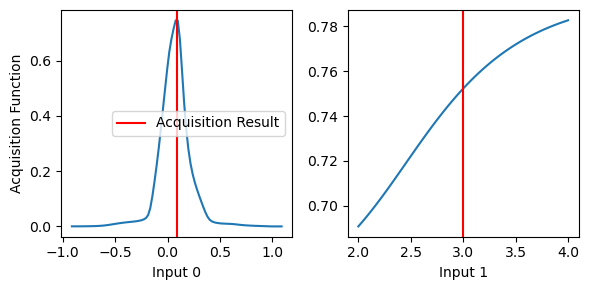

In [18]:
# acq = optimizer.generator.get_acquisition(optimizer.generator.model)

# last_acq = np.vstack(data_all[0].iloc[-1][list(vocs.variable_data([vocs.random_inputs()], '').keys())].values[:]).astype(float)
# last_acq = torch.tensor(last_acq).reshape(1,-1)

last_acq = res[0]
# last_acq = torch.tensor(optimizer.data[vocs.variable_names].iloc[-1].to_numpy().reshape(1,-1))

fig, axs = plt.subplots(1, ndim)
    
fig.set_size_inches(3*(ndim), 3)

for scan_dim in range(ndim):
    X_scan = last_acq.repeat(100,1)
#     ls = torch.linspace(*vocs.bounds.T[scan_dim],100)
    ls = torch.linspace(last_acq[0,scan_dim]-1,last_acq[0,scan_dim]+1,100)

    X_scan[:,scan_dim] = ls

    acq_scan = torch.tensor([acq(X.reshape(1,-1)) for X in X_scan]).reshape(-1)
    
    ax = axs[scan_dim]
    
    ax.plot(ls.cpu(), acq_scan.detach().cpu())
    ax.axvline(last_acq[0,scan_dim].cpu(), c='r', label='Acquisition Result')
    
    
    ax.set_xlabel('Input ' + str(scan_dim))
    
    if scan_dim == 0:
        ax.set_ylabel('Acquisition Function')
        ax.legend()
    
plt.tight_layout()
plt.show()

In [ ]:
from emitopt.utils import plot_sample_optima_convergence_inputs
plot_sample_optima_convergence_inputs(results, show_valid_only=False)

In [ ]:
from emitopt.utils import plot_sample_optima_convergence_emits
plot_sample_optima_convergence_emits(results)

In [ ]:
from emitopt.utils import plot_valid_emit_prediction_at_x_tuning

x_tuned = torch.mean(results[n_iter]['x_stars_all'], dim=0, keepdim=True)
print('x_tuned =', x_tuned)
plot_valid_emit_prediction_at_x_tuning(beam_size_model_x, 
                                       x_tuned, 
                                       scale_factor = algo_kwargs['scale_factor'],
                                       q_len = algo_kwargs['q_len'],
                                       distance = algo_kwargs['distance'],
                                       bounds = vocs.bounds,
                                       meas_dim = algo_kwargs['meas_dim'],
                                       n_samples = 10000,
                                       n_steps_quad_scan = 10
                                        )

# Plot some beam size surface samples from our current model and do a scan of the predicted emittance as a function of our single tuning parameter.

In [ ]:
if ndim==2:
    
    device = torch.tensor(1).device
    torch.set_default_tensor_type('torch.DoubleTensor')

    fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"})
    fig.set_size_inches(15,10)

    ax = axs[0]

    for s in range(3):

        # plot first 3 beam size surface samples
        xlin, ylin = torch.arange(-3,1,0.05), torch.arange(-40,40, 1.)
        X, Y = torch.meshgrid(xlin, ylin)
        XY = torch.cat((X.reshape(-1,1), Y.reshape(-1,1)), dim=1)
        print(XY.shape)
        Z = optimizer.generator.algorithm_results['post_paths_cpu'](XY)[s].reshape(X.shape).detach()
        cmap='viridis'
        surf = ax.plot_surface(Y, X, Z, cmap=cmap,
                               linewidth=0, antialiased=True, alpha=0.3, rasterized=True)

        # add orange parabolic highlights
        ax.plot(Y[0,:].numpy(), Z[0,:].numpy(), zs=X[0,0].item(), zdir='y', c='C1', lw=2, zorder=10)
        ax.plot(Y[int(len(Z[0,:])/2),:].numpy(), Z[int(len(Z[0,:])/2),:].numpy(), zs=X[int(len(Z[0,:])/2),0].item(), zdir='y', c='C1', lw=2)
        ax.plot(Y[-1,:].numpy(), Z[-1,:].numpy(), zs=X[-1,0].item(), zdir='y', c='C1', lw=2)




    # plot initial observations
    x0 = torch.tensor(optimizer.data['x0'].values)[:n_obs_init]
    x1 = torch.tensor(optimizer.data['x1'].values)[:n_obs_init]
    y = torch.tensor([item.item() for item in optimizer.data['y'].values])[:n_obs_init]
    ax.scatter(x1.flatten(), x0.flatten(), y.flatten(), marker='o', c='C0', alpha=1, s=80, label='Random (Initial) Observations', zorder=15)

    # plot bax observations
    x0 = torch.tensor(optimizer.data['x0'].values)[n_obs_init:]
    x1 = torch.tensor(optimizer.data['x1'].values)[n_obs_init:]
    y = torch.tensor([item.item() for item in optimizer.data['y'].values])[n_obs_init:]
    ax.scatter(x1.flatten(), x0.flatten(), y.flatten(), marker='o', c='C1', alpha=1, s=80, label='BAX Observations', zorder=15)

    ax.set_title('Beam Size Surface Samples')
    ax.set_ylabel('Tuning Parameter')
    ax.set_xlabel('Measurement Parameter')
    ax.set_zlabel('Beam Size Squared')

    ax.set_ylim(-3, 1)
    ax.set_zlim(0)
    
    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    ax.legend()
    ax.dist = 12

    
    
    if device.type == "cuda":
        torch.set_default_tensor_type("torch.cuda.DoubleTensor")
        
   

    # do a scan (along the tuning dimension) of our emittance predictions
    emit_lowers = torch.tensor([])
    emit_uppers = torch.tensor([])
    emit_meds = torch.tensor([])
    for tuning_param in xlin:
        x_tuning = tuning_param.reshape(1,-1).to(device)
        emits, svr = get_valid_emittance_samples(beam_size_model, 
                                                 scale_factor, 
                                                 0.108, 
                                                 2.26, 
                                                 x_tuning, 
                                                 vocs.bounds.T, 
                                                 meas_dim, 
                                                 n_samples=100000, 
                                                 n_steps_quad_scan=10)
        emit_lower = torch.quantile(emits, q=0.025, dim=0)
        emit_upper = torch.quantile(emits, q=0.975, dim=0)
        emit_med = torch.quantile(emits, q=0.5, dim=0)

        emit_lowers = torch.cat((emit_lowers, emit_lower))
        emit_uppers = torch.cat((emit_uppers, emit_upper))
        emit_meds = torch.cat((emit_meds, emit_med))

    #get a few batches of n_samples pathwise sample optima
    x_stars_all = torch.tensor([])
    emit_stars_all = torch.tensor([])
    for i in range(5):
        algo = optimizer.generator.algorithm
        results_dict = algo.get_execution_paths(beam_size_model, torch.tensor(vocs.bounds))[-1]
        x_stars = results_dict['x_stars']
        emit_stars = results_dict['emit_stars'].detach()
        x_stars_all = torch.cat((x_stars_all, x_stars), dim=0)
        emit_stars_all = torch.cat((emit_stars_all, emit_stars), dim=0)
    
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    import matplotlib.patches as mpatches

    ax = axs[1]
    
    # plot median emittance curve
    medline, = ax.plot(emit_meds.cpu().numpy(), xlin.numpy(), zs=0, zdir='z', c='g', label='Median')
    
    opt_cross = ax.scatter(emit_stars_all.flatten().cpu(), x_stars_all.flatten().cpu(), zs=0, zdir='z', marker='x', s=40, c='m', alpha=0.5, label='Sample Optima')
    
    # plot emittance 95% confidence interval as a Poly3DCollection (ordering of vertices matters)
    verts = (
        [(emit_lowers[i].item(), xlin[i].item(), 0) for i in range(len(xlin))] + 
        [(emit_uppers[i].item(), xlin[i].item(), 0) for i in range(len(xlin))][::-1]
    )
    ax.add_collection3d(Poly3DCollection([verts],color='g', edgecolor='None', alpha=0.5)) # Add a polygon instead of fill_between

    
    ax.set_xlabel('Emittance')
    ax.set_ylabel('Tuning Parameter')
    ax.set_title('Emittance Measurement Samples')
    
    ax.set_xlim(0,25)
    ax.set_ylim(-3,1)
    ax.set_zlim(0,1)

    # remove vertical tick marks
    ax.set_zticks([])

    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    orange_patch = mpatches.Patch(color='g', alpha=0.5, label='95% C.I.')
    ax.legend(handles=[medline, orange_patch, opt_cross])
    ax.dist = 12

    
    
    ax = axs[2]
    bins = 10
    freq, edges = torch.histogram(x_stars_all.flatten().cpu(), bins=bins, density=True)
    for i in range(bins):
        uverts = []
        lverts = []
        uverts += [(freq[i].item(), edges[i].item(), 0), (freq[i].item(), edges[i+1].item(), 0)]
        lverts += [(0, edges[i+1].item(), 0), (0, edges[i].item(), 0)]
        verts = uverts + lverts
        ax.add_collection3d(Poly3DCollection([verts],color='m', edgecolor='k')) # Add a polygon instead of fill_between

    ax.set_title('Distribution of Sample Optimal Tuning Parameters')
    ax.set_ylabel('Tuning Parameter')
    ax.set_xlabel('Frequency')
    
    ax.set_xlim(0,2)
    ax.set_ylim(-3,1)
    ax.set_zlim(0,1)
    
    # remove vertical tick marks
    ax.set_zticks([])

    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.dist = 12

    plt.tight_layout()
    plt.savefig('beamsize-surfaces-with-emittance-1.svg', format='svg')
    plt.show()


# Minimize sample emittance functions produced by current GP beam size model and inspect results

In [16]:
#select sample result

sid = 5 #sample index to examine

# X_tuned = X_sample_opt[sid].reshape(1,-1)
X_tuned = optimizer.generator.algorithm_results['x_stars'][sid:sid+1, :]
# X_tuned = torch.zeros(1,ndim-1)
print('X_tuned =', X_tuned)

X_tuned = tensor([[ 0.2198, -0.0338]])


# Sample geometric mean of emittance x&y

tensor([-9.0134e+00, -7.2108e+00, -5.4081e+00, -3.6054e+00, -1.8027e+00,
        -3.3356e-16,  1.8027e+00,  3.6054e+00,  5.4081e+00,  7.2108e+00,
         9.0134e+00])
tensor([[ 0.0632,  0.3324,  0.4484,  ..., -2.0735, -3.0302, -4.1401],
        [ 0.0257,  0.3000,  0.4194,  ..., -2.1194, -3.0850, -4.2057],
        [-0.0057,  0.2730,  0.3956,  ..., -2.1473, -3.1175, -4.2438],
        ...,
        [ 0.3609, -0.0252, -0.3155,  ..., -0.0441,  0.3366,  0.8131],
        [ 0.2736, -0.1072, -0.3923,  ..., -0.0943,  0.2902,  0.7703],
        [ 0.1748, -0.2017, -0.4824,  ..., -0.1574,  0.2317,  0.7165]],
       grad_fn=<ReshapeAliasBackward0>)
tensor([ 9.0134e+00,  7.2108e+00,  5.4081e+00,  3.6054e+00,  1.8027e+00,
         3.3356e-16, -1.8027e+00, -3.6054e+00, -5.4081e+00, -7.2108e+00,
        -9.0134e+00])
tensor([[ 0.0854,  0.6978,  1.9091,  ..., 21.7540, 27.1577, 33.1602],
        [ 0.0697,  0.7347,  2.0504,  ..., 23.6093, 29.4799, 36.0013],
        [ 0.0542,  0.7704,  2.1878,  ..., 25.4162,

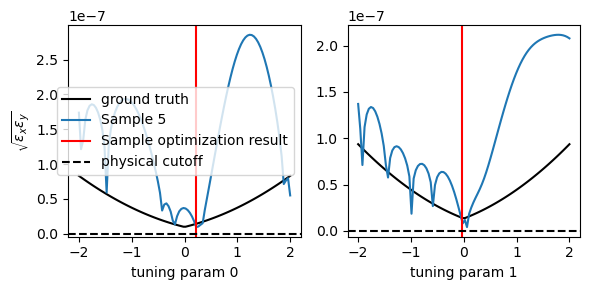

In [17]:
from emitopt.utils import post_path_emit_squared_thick_quad

fig, axs = plt.subplots(1, ndim-1)
if ndim == 2: axs = [axs]
    
fig.set_size_inches(3*(ndim-1), 3)

for scan_dim in range(ndim-1):
    X_tuning_scan = X_tuned.repeat(100,1)
    ls = torch.linspace(-2,2,100)
    X_tuning_scan[:,scan_dim] = ls
    X_meas = torch.linspace(-3,3,11)

    emit_sq_x = post_path_emit_squared_thick_quad(optimizer.generator.algorithm_results['post_paths_cpu_xy'][0], 
                              1*optimizer.generator.algorithm.scale_factor, 
                              optimizer.generator.algorithm.q_len, 
                              optimizer.generator.algorithm.distance, 
                              X_tuning_scan.cpu(), meas_dim, X_meas.cpu(), samplewise=False)[0]
    emit_sq_y = post_path_emit_squared_thick_quad(optimizer.generator.algorithm_results['post_paths_cpu_xy'][1], 
                              -1*optimizer.generator.algorithm.scale_factor, 
                              optimizer.generator.algorithm.q_len, 
                              optimizer.generator.algorithm.distance, 
                              X_tuning_scan.cpu(), meas_dim, X_meas.cpu(), samplewise=False)[0]
    geo_mean_emit = torch.sqrt(emit_sq_x.abs().sqrt() * emit_sq_y.abs().sqrt())
    
    ax = axs[scan_dim]
    
#     ax.plot(ls.cpu(), (toy_emit_nd(ls.reshape(-1,1))**2).cpu(), c='k', label='Ground truth') #this ground truth isn't exactly the matching cross-section but it should be close
    gt_emits = ground_truth_geometric_mean_emittance(emit_min=9.033454852412253e-09, x_tuning=X_tuning_scan)
    ax.plot(ls, gt_emits, c='k', label='ground truth')
#     ax.plot(ls, 9.033454852412253e-09 * (1+ls.abs())**2, c='k', label='ground truth')
    ax.plot(ls.cpu(), geo_mean_emit[sid].detach().cpu()*1.e-6, label='Sample ' + str(sid))
    ax.axvline(X_tuned[0,scan_dim].cpu(), c='r', label='Sample optimization result')
    ax.axhline(0, c='k', ls='--', label='physical cutoff')
    
    ax.set_xlabel('tuning param ' + str(scan_dim))
    
    if scan_dim == 0:
        ax.set_ylabel('$\sqrt{\epsilon_x\epsilon_y}$')
        ax.legend()
    
plt.tight_layout()
plt.show()


# Plot posterior mean model of geometric mean emttance x&y

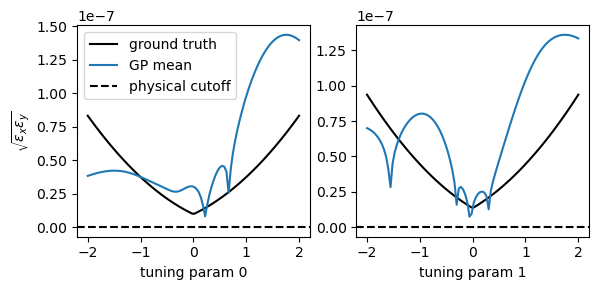

In [18]:
from emitopt.utils import post_mean_emit_squared_thick_quad

fig, axs = plt.subplots(1, ndim-1)
if ndim == 2: axs = [axs]
    
fig.set_size_inches(3*(ndim-1), 3)

for scan_dim in range(ndim-1):
    X_tuning_scan = X_tuned.repeat(100,1)
    ls = torch.linspace(-2,2,100)
    X_tuning_scan[:,scan_dim] = ls
    X_meas = torch.linspace(-3,3,11)

    emit_sq_x = post_mean_emit_squared_thick_quad(
        model=beam_size_model_x,
        scale_factor=1*optimizer.generator.algorithm.scale_factor,
        q_len=optimizer.generator.algorithm.q_len,
        distance=optimizer.generator.algorithm.distance,
        x_tuning=X_tuning_scan.cpu(),
        meas_dim=meas_dim,
        x_meas=X_meas.cpu(),
    )[0]
    emit_sq_y = post_mean_emit_squared_thick_quad(
        model=beam_size_model_y,
        scale_factor=-1*optimizer.generator.algorithm.scale_factor,
        q_len=optimizer.generator.algorithm.q_len,
        distance=optimizer.generator.algorithm.distance,
        x_tuning=X_tuning_scan.cpu(),
        meas_dim=meas_dim,
        x_meas=X_meas.cpu(),
    )[0]    
    geo_mean_emit = torch.sqrt(emit_sq_x.abs().sqrt() * emit_sq_y.abs().sqrt())
    ax = axs[scan_dim]
    
#     ax.plot(ls.cpu(), (toy_emit_nd(ls.reshape(-1,1))**2).cpu(), c='k', label='Ground truth') #this ground truth isn't exactly the matching cross-section but it should be close

#     ax.plot(ls, 9.033454852412253e-09 * (1+ls.abs())**2, c='k', label='ground truth')
    gt_emits = ground_truth_geometric_mean_emittance(emit_min=9.033454852412253e-09, x_tuning=X_tuning_scan)
    ax.plot(ls, gt_emits, c='k', label='ground truth')
    ax.plot(ls.cpu(), geo_mean_emit.detach().cpu()*1.e-6, label='GP mean')
    ax.axhline(0, c='k', ls='--', label='physical cutoff')
    
    ax.set_xlabel('tuning param ' + str(scan_dim))
    
    if scan_dim == 0:
        ax.set_ylabel('$\sqrt{\epsilon_x\epsilon_y}$')
        ax.legend()
    
plt.tight_layout()
plt.show()

In [45]:
X_tuned = optimizer.generator.algorithm_results['x_stars'][sid:sid+1, :]
X_tuned

tensor([[ 0.2198, -0.0338]])

x_tuning: tensor([[ 0.2198, -0.0338]])


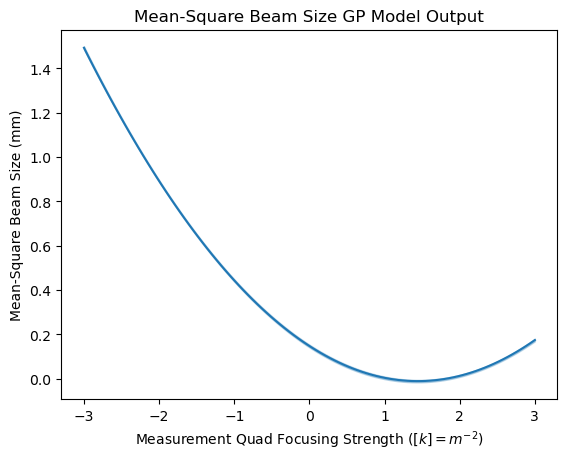

In [46]:
from emitopt.utils import get_meas_scan_inputs_from_tuning_configs
x_meas = torch.linspace(-3,3,100)
x_tuning = X_tuned
# x_tuning = torch.tensor([[ 0., 0.]])
# x_tuning = torch.tensor([[ 0., 0.]])
x_meas_scan = get_meas_scan_inputs_from_tuning_configs(meas_dim=meas_dim, x_tuning=x_tuning, x_meas=x_meas)

bss_posterior = beam_size_model_x.posterior(x_meas_scan)
bss_mean = bss_posterior.mean.flatten().detach()
bss_var = bss_posterior.variance.flatten().detach()
plt.plot(x_meas, bss_mean.detach())
plt.fill_between(x_meas, (bss_mean-bss_var.sqrt()), (bss_mean+bss_var.sqrt()), color='C0', alpha=0.3)
plt.title('Mean-Square Beam Size GP Model Output')
plt.xlabel('Measurement Quad Focusing Strength ($[k]=m^{-2}$)')
plt.ylabel('Mean-Square Beam Size (mm)')
print("x_tuning:", x_tuning)
# textstr = r"$x_tuning=%d$" % (x_tuning,)

# # these are matplotlib.patch.Patch properties
# props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# # place a text box in upper left in axes coords
# plt.text(
#     0.95,
#     0.05,
#     textstr,
#     transform=ax.transAxes,
#     fontsize=14,
#     verticalalignment="bottom",
#     horizontalalignment="right",
#     bbox=props,
# )

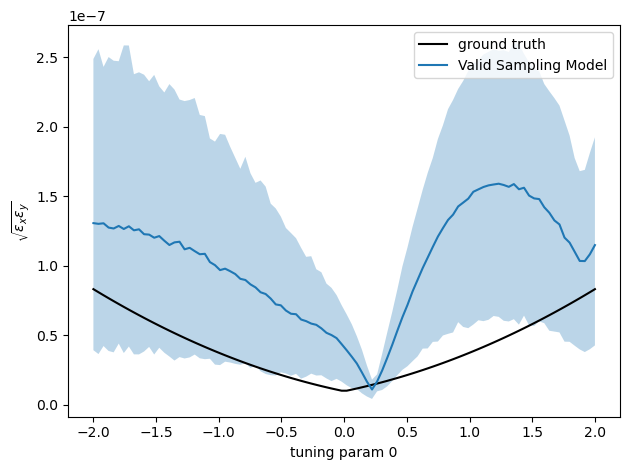

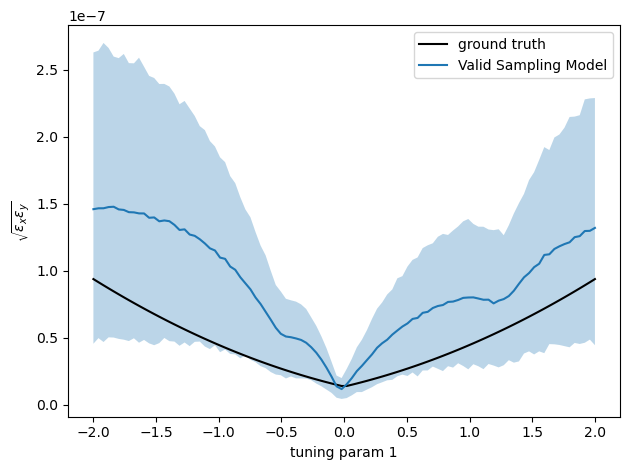

In [19]:
from emitopt.utils import get_valid_geo_mean_emittance_samples_thick_quad


for scan_dim in range(ndim-1):
    X_tuning_scan = X_tuned.repeat(100,1)
    ls = torch.linspace(-2,2,100)
    X_tuning_scan[:,scan_dim] = ls
    X_meas = torch.linspace(-3,3,11)
    
    emit_mean, emit_lower, emit_upper = torch.tensor([]), torch.tensor([]), torch.tensor([])
    for i in range(len(X_tuning_scan)):
        emit_valid, svr = get_valid_geo_mean_emittance_samples_thick_quad(
            model=bax_model,
            scale_factor=optimizer.generator.algorithm.scale_factor,
            q_len=optimizer.generator.algorithm.q_len,
            distance=optimizer.generator.algorithm.distance,
            x_tuning=X_tuning_scan[i:i+1],
            domain=optimizer.generator.vocs.bounds.T,
            meas_dim=meas_dim,
            n_samples=10000,
            n_steps_quad_scan=10,
            visualize=False,
        )
        mean = emit_valid.mean()
        lower = torch.quantile(emit_valid, q=0.025)
        upper = torch.quantile(emit_valid, q=0.975)
        emit_mean = torch.cat((emit_mean, torch.tensor([mean])))
        emit_lower = torch.cat((emit_lower, torch.tensor([lower])))
        emit_upper = torch.cat((emit_upper, torch.tensor([upper])))

#     plt.plot(ls, 9.033454852412253e-09 * (1+ls.abs())**2, c='k', label='ground truth')
    gt_emits = ground_truth_geometric_mean_emittance(emit_min=9.033454852412253e-09, x_tuning=X_tuning_scan)
    plt.plot(ls, gt_emits, c='k', label='ground truth')
    plt.plot(ls, emit_mean*1.e-6, label='Valid Sampling Model')
    plt.fill_between(ls, emit_lower*1.e-6, emit_upper*1.e-6, alpha=0.3)
    plt.xlabel('tuning param ' + str(scan_dim))
    plt.ylabel('$\sqrt{\epsilon_x\epsilon_y}$')
#     plt.ylim(0,1.81e-7)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [58]:
bss_model_x, bss_model_y = bax_model.models
bss_x = bss_model_x.outcome_transform.untransform(bss_model_x.train_targets)[0]
bss_y = bss_model_y.outcome_transform.untransform(bss_model_y.train_targets)[0]
bss = torch.sqrt(bss_x * bss_y)
x_smallest_observed_beamsize = bss_model_x._original_train_inputs[torch.argmin(bss)].reshape(1,-1)

tuning_dims = list(range(vocs.bounds.shape[1]))
tuning_dims.remove(meas_dim)
tuning_dims = torch.tensor(tuning_dims)
x_tuning_best = torch.index_select(x_smallest_observed_beamsize, dim=1, index=tuning_dims)
x_tuning_best
x_tuning_init = x_tuning_best.repeat(n_samples,1).flatten()
x_tuning_init

tensor([-0.1097, -0.1097, -0.1097, -0.1097, -0.1097, -0.1097, -0.1097, -0.1097,
        -0.1097, -0.1097])

In [ ]:
bss_model_x, bss_model_y = model.models
bss_x = bss_model_x.outcome_transform.untransform(bss_model_x.train_targets)[0]
bss_y = bss_model_y.outcome_transform.untransform(bss_model_y.train_targets)[0]
bss = torch.sqrt(bss_x * bss_y)
x_smallest_observed_beamsize = bss_model_x._original_train_inputs[torch.argmin(bss)].reshape(1,-1)

tuning_dims = list(range(bounds.shape[1]))
tuning_dims.remove(meas_dim)
tuning_dims = torch.tensor(tuning_dims)
x_tuning_best = torch.index_select(x_smallest_observed_beamsize, dim=1, index=tuning_dims)
x_tuning_init = x_tuning_best.repeat(n_samples,1).flatten()


array([[-2., -3., -2., -2.],
       [ 2.,  3.,  2.,  2.]])

In [53]:
tuning_dims = list(range(vocs.bounds.shape[1]))
tuning_dims.remove(meas_dim)
tuning_dims

[0]

In [24]:
bss_model_x, bss_model_y = model.models
bss_model_x.input_transform.untransform(bss_model_x.train_inputs[0])

tensor([[ 0.2560,  1.0180],
        [ 1.8963,  1.7721],
        [-0.1986, -0.7156],
        [ 0.2587,  1.2021],
        [ 0.3185,  1.3990],
        [-0.3192,  2.5306],
        [ 0.3152,  2.7959],
        [ 0.3188, -2.5670],
        [ 0.1120,  3.0000],
        [ 0.2625, -1.6433],
        [ 0.2587, -3.0000],
        [ 0.2466,  1.6852],
        [ 0.2813, -0.9876],
        [ 0.2303,  3.0000],
        [ 0.2629, -1.0331],
        [ 0.2565,  0.2174],
        [ 0.2627, -2.0131],
        [ 0.2549,  1.2289],
        [-0.2007,  1.7828],
        [ 0.2504, -2.3205],
        [ 0.2364, -0.0105],
        [ 0.3433,  1.3335],
        [ 0.2566, -2.7943],
        [ 0.2357,  2.5645],
        [ 0.2411, -0.5509],
        [ 0.2418, -2.0491],
        [ 0.1951,  0.7680],
        [ 0.1943, -1.9778],
        [ 0.2378,  2.8755],
        [ 0.2188,  1.2120],
        [ 0.2260, -3.0000],
        [ 0.1828,  1.2987],
        [ 0.2363, -1.0324],
        [ 0.2639,  2.0646],
        [ 0.2224, -1.5779],
        [ 0.2214, -1

In [21]:
optimizer.generator.algorithm_results['x_stars']

tensor([[-0.0469, -0.2030, -0.0585],
        [-0.0671, -0.2061, -0.0548],
        [-0.0604, -0.2116, -0.0548],
        [-0.0644, -0.2111, -0.0519],
        [-0.0586, -0.2191, -0.0403],
        [-0.0609, -0.2187, -0.0571],
        [-0.0600, -0.2160, -0.0438],
        [-0.0505, -0.2053, -0.0541],
        [-0.0587, -0.2131, -0.0548],
        [-0.0565, -0.2064, -0.0530]])

In [40]:
bss_model_x._original_train_inputs

tensor([[ 0.2560,  1.0180],
        [ 1.8963,  1.7721],
        [-0.1986, -0.7156],
        [ 0.2587,  1.2021],
        [ 0.3185,  1.3990],
        [-1.7815,  0.9012],
        [ 0.8566, -0.2661],
        [-1.3724, -0.8278],
        [-0.3147, -0.8555],
        [-0.7083,  0.6740],
        [ 0.5376, -2.1555],
        [ 0.2078, -2.1212],
        [ 0.9968,  2.4896],
        [-0.2049,  1.0317],
        [ 1.4390, -2.0089],
        [-1.8156, -3.0000],
        [ 0.7799,  2.9927],
        [ 0.2980,  3.0000],
        [-0.2594, -3.0000],
        [-0.1097, -1.5611],
        [ 0.4927,  1.8555],
        [-0.4226,  2.6019],
        [ 1.6686, -0.5787],
        [ 0.1038,  2.2395],
        [ 0.9231, -3.0000],
        [ 1.2025,  1.9304],
        [-1.9846,  2.5058],
        [ 1.8156, -2.4964],
        [ 0.1948, -2.4973],
        [-0.1724,  2.4261],
        [-0.6865,  2.9858],
        [ 1.3775,  2.3977],
        [-0.9643,  2.1539],
        [-1.6850,  2.7211],
        [-0.5988, -2.4703],
        [-0.3471, -0

In [41]:
bss_model_x._original_train_targets

AttributeError: 'SingleTaskGP' object has no attribute '_original_train_targets'

In [23]:
emit_mean

tensor([0.1151, 0.1065, 0.1132, 0.1187, 0.1192, 0.1171, 0.1143, 0.1111, 0.1068,
        0.1025, 0.0977, 0.0921, 0.0872, 0.0815, 0.0759, 0.0715, 0.0676, 0.0639,
        0.0598, 0.0551, 0.0498, 0.0453, 0.0436, 0.0453, 0.0475, 0.0485, 0.0481,
        0.0468, 0.0447, 0.0426, 0.0403, 0.0382, 0.0368, 0.0357, 0.0345, 0.0331,
        0.0314, 0.0293, 0.0273, 0.0256, 0.0243, 0.0234, 0.0222, 0.0208, 0.0187,
        0.0162, 0.0141, 0.0128, 0.0115, 0.0106, 0.0104, 0.0115, 0.0128, 0.0141,
        0.0158, 0.0176, 0.0192, 0.0211, 0.0226, 0.0238, 0.0246, 0.0257, 0.0268,
        0.0277, 0.0284, 0.0285, 0.0279, 0.0277, 0.0281, 0.0284, 0.0289, 0.0296,
        0.0313, 0.0341, 0.0366, 0.0388, 0.0416, 0.0455, 0.0490, 0.0517, 0.0537,
        0.0561, 0.0592, 0.0630, 0.0668, 0.0705, 0.0738, 0.0762, 0.0787, 0.0820,
        0.0858, 0.0905, 0.0959, 0.1017, 0.1069, 0.1107, 0.1134, 0.1156, 0.1163,
        0.1223])

In [20]:
emit_valid.shape

torch.Size([839020, 1])

In [42]:
9.033454852412253e-09 * (1+ls.abs())

tensor([2.7100e-08, 2.6735e-08, 2.6370e-08, 2.6005e-08, 2.5640e-08, 2.5275e-08,
        2.4910e-08, 2.4545e-08, 2.4180e-08, 2.3815e-08, 2.3450e-08, 2.3085e-08,
        2.2721e-08, 2.2356e-08, 2.1991e-08, 2.1626e-08, 2.1261e-08, 2.0896e-08,
        2.0531e-08, 2.0166e-08, 1.9801e-08, 1.9436e-08, 1.9071e-08, 1.8706e-08,
        1.8341e-08, 1.7976e-08, 1.7611e-08, 1.7246e-08, 1.6881e-08, 1.6516e-08,
        1.6151e-08, 1.5786e-08, 1.5421e-08, 1.5056e-08, 1.4691e-08, 1.4326e-08,
        1.3961e-08, 1.3596e-08, 1.3231e-08, 1.2866e-08, 1.2501e-08, 1.2136e-08,
        1.1771e-08, 1.1406e-08, 1.1041e-08, 1.0676e-08, 1.0311e-08, 9.9459e-09,
        9.5809e-09, 9.2159e-09, 9.2159e-09, 9.5809e-09, 9.9459e-09, 1.0311e-08,
        1.0676e-08, 1.1041e-08, 1.1406e-08, 1.1771e-08, 1.2136e-08, 1.2501e-08,
        1.2866e-08, 1.3231e-08, 1.3596e-08, 1.3961e-08, 1.4326e-08, 1.4691e-08,
        1.5056e-08, 1.5421e-08, 1.5786e-08, 1.6151e-08, 1.6516e-08, 1.6881e-08,
        1.7246e-08, 1.7611e-08, 1.7976e-

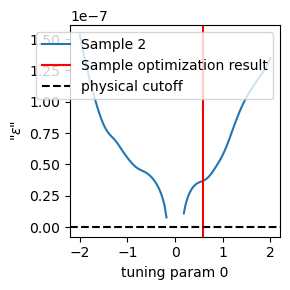

In [20]:
from emitopt.utils import post_mean_emit_squared_thick_quad

fig, axs = plt.subplots(1, ndim-1)
if ndim == 2: axs = [axs]
    
fig.set_size_inches(3*(ndim-1), 3)

for scan_dim in range(ndim-1):
    X_tuning_scan = X_tuned.repeat(100,1)
    ls = torch.linspace(-2,2,100)
    X_tuning_scan[:,scan_dim] = ls
    X_meas = torch.linspace(-3,3,11)

    emits_sq = post_mean_emit_squared_thick_quad(
        model=beam_size_model_y,
        scale_factor=-1*optimizer.generator.algorithm.scale_factor,
        q_len=optimizer.generator.algorithm.q_len,
        distance=optimizer.generator.algorithm.distance,
        x_tuning=X_tuning_scan.cpu(),
        meas_dim=meas_dim,
        x_meas=X_meas.cpu(),
    )[0]
    
    ax = axs[scan_dim]
    
#     ax.plot(ls.cpu(), (toy_emit_nd(ls.reshape(-1,1))**2).cpu(), c='k', label='Ground truth') #this ground truth isn't exactly the matching cross-section but it should be close

    ax.plot(ls.cpu(), emits_sq.detach().cpu().sqrt()*1.e-6, label='Sample ' + str(sid))
    ax.axvline(X_tuned[0,scan_dim].cpu(), c='r', label='Sample optimization result')
    ax.axhline(0, c='k', ls='--', label='physical cutoff')
    
    ax.set_xlabel('tuning param ' + str(scan_dim))
    
    if scan_dim == 0:
        ax.set_ylabel('"$\epsilon$"')
        ax.legend()
    
plt.tight_layout()
plt.show()

In [37]:
from emitopt.utils import compute_emit_bmag_thick_quad
k = torch.tensor([ 40., -10., -60.])
y_batch = torch.tensor([[1777.4973,  680.4423, 8194.3948]])
compute_emit_bmag_thick_quad(k, y_batch, q_len, distance)

(tensor([[37.1184]]),
 tensor([[10.4638]]),
 tensor([[[23.6403],
          [ 0.9856],
          [58.3219]]]),
 tensor([True]))

In [23]:
optimizer.generator.algorithm_results['x_stars']

tensor([[ 1.0000,  1.0000],
        [ 1.0000, -3.0000],
        [-0.2361,  0.3363],
        [-0.1264, -0.1065],
        [ 0.0420, -0.2993],
        [-0.2420, -0.4340],
        [-3.0000,  1.0000],
        [ 0.6247,  0.4942],
        [ 0.0353,  0.2425],
        [ 0.5291,  1.0000]])

In [ ]:
from emitopt.utils import plot_model_cross_section

In [ ]:
scan_dict = {'x0':[-3.0, 1.0], 'x1': [-40.0, 40.0], 'x2': 1., 'x3': 0.}
plot_model_cross_section(beam_size_model, vocs, scan_dict, nx=50, ny=15)

In [ ]:
from emitopt.utils import (propagate_sig, 
                            build_quad_rmat, fit_gp_quad_scan, 
                            plot_valid_thick_quad_fits
                          )

def compute_emit_bmag_thick_quad(k, y_batch, q_len, rmat_quad_to_screen, beta0=1., alpha0=0.):
    """
    A function that computes the emittance(s) corresponding to a set of quadrupole measurement scans
    using a thick quad model.

    Parameters:
        k: 1d torch tensor of shape (n_steps_quad_scan,)
            representing the measurement quad geometric focusing strengths in [m^-2]
            used in the emittance scan

        y_batch: 2d torch tensor of shape (n_scans x n_steps_quad_scan),
                where each row represents the mean-square beamsize outputs in [m^2] of an emittance scan
                with inputs given by k

        q_len: float defining the (longitudinal) quadrupole length or "thickness" in [m]
         
        rmat_quad_to_screen: the (fixed) 2x2 R matrix describing the transport from the end of the 
                measurement quad to the observation screen.

        beta0: the design beta twiss parameter at the screen
        
        alpha0: the design alpha twiss parameter at the screen
        
    Returns:
        emit: shape (n_scans x 1) containing the geometric emittance fit results for each scan
        bmag_min: (n_scans x 1) containing the bmag corresponding to the optimal point for each scan
        sig: shape (n_scans x 3 x 1) containing column vectors of [sig11, sig12, sig22]
        is_valid: 1d tensor identifying physical validity of the emittance fit results
        
    SOURCE PAPER: http://www-library.desy.de/preparch/desy/thesis/desy-thesis-05-014.pdf
    """
    
    # construct the A matrix from eq. (3.2) & (3.3) of source paper
    quad_rmats = build_quad_rmat(k, q_len) # result shape (len(k) x 2 x 2)
    total_rmats = rmat_quad_to_screen.reshape(1,2,2) @ quad_rmats # result shape (len(k) x 2 x 2)
    
    amat = torch.tensor([]) # prepare the A matrix
    for rmat in total_rmats:
        r11, r12 = rmat[0,0], rmat[0,1]
        amat = torch.cat((amat, torch.tensor([[r11**2, 2.*r11*r12, r12**2]])), dim=0)
    # amat result shape (len(k) x 3)
    
    # get sigma matrix elements just before measurement quad from pseudo-inverse
    sig = amat.pinverse().unsqueeze(0) @ y_batch.unsqueeze(-1) # shapes (1 x 3 x len(k)) @ (n_scans x len(k) x 1)
    # result shape (n_scans x 3 x 1) containing column vectors of [sig11, sig12, sig22]
    
    # compute emit
    emit = torch.sqrt(sig[:,0,0]*sig[:,2,0] - sig[:,1,0]**2).reshape(-1,1) # result shape (n_scans x 1)

    # check sigma matrix and emit for physical validity
    is_valid = torch.logical_and(sig[:,0,0] > 0, sig[:,2,0] > 0) # result 1d tensor
    is_valid = torch.logical_and(is_valid, ~torch.isnan(emit.flatten())) # result 1d tensor
    
    # propagate beam parameters to screen
    twiss_at_screen = propagate_sig(sig, emit, total_rmats)[1]
    # result shape (n_scans x len(k) x 3 x 1)
    
    # get design gamma0 from design beta0, alpha0
    gamma0 = (1 + alpha0**2) / beta0
    
    # compute bmag
    bmag = 0.5 * (twiss_at_screen[:,:,0,0] * gamma0
                - 2 * twiss_at_screen[:,:,1,0] * alpha0
                + twiss_at_screen[:,:,2,0] * beta0
               )
    # result shape (n_scans, n_steps_quad_scan)
    
    # select minimum bmag from quad scan
    bmag_min, bmag_min_id = torch.min(bmag, dim=1, keepdim=True) # result shape (n_scans, 1) 
    
    return emit, bmag_min, sig, is_valid

def get_valid_emit_bmag_samples_from_quad_scan(
    k,
    y,
    q_len,
    rmat_quad_to_screen,
    beta0=1.,
    alpha0=0.,
    n_samples=10000,
    n_steps_quad_scan=10,
    covar_module=None,
    visualize=False,
    tkwargs=None,
):
    """
    A function that produces a distribution of possible (physically valid) emittance values corresponding
    to a single quadrupole measurement scan. Data is first modeled by a SingleTaskGP, virtual measurement
    scan samples are then drawn from the model posterior, the samples are modeled by thick-quad transport
    to obtain fits to the beam parameters, and physically invalid results are discarded.

    Parameters:

        k: 1d numpy array of shape (n_steps_quad_scan,)
        representing the measurement quad geometric focusing strengths in [m^-2]
        used in the emittance scan

        y: 1d numpy array of shape (n_steps_quad_scan, )
            representing the root-mean-square beam size measurements in [m] of an emittance scan
            with inputs given by k

        q_len: float defining the (longitudinal) quadrupole length or "thickness" in [m]

        rmat_quad_to_screen: the (fixed) 2x2 R matrix describing the transport from the end of the 
                measurement quad to the observation screen.

        beta0: the design beta twiss parameter at the screen
        
        alpha0: the design alpha twiss parameter at the screen
        
        n_samples: the number of virtual measurement scan samples to evaluate for our "Bayesian" estimate

        n_steps_quad_scan: the number of steps in our virtual measurement scans

        covar_module: the covariance module to be used in fitting of the SingleTaskGP 
                    (modeling the function y**2 vs. k)
                    If None, uses ScaleKernel(MaternKernel()).

        visualize: boolean. Set to True to plot the parabolic fitting results.

        tkwargs: dict containing the tensor device and dtype

    Returns:
        emits_valid: a tensor of physically valid emittance results from sampled measurement scans.

        bmag_valid: (n_valid_scans x 1) containing the bmag corresponding to the optimal point 
                        from each physically valid fit.

        sig_valid: tensor, shape (n_valid_scans x 3 x 1), containing the computed 
                        sig11, sig12, sig22 corresponding to each physically valid
                        fit.

        sample_validity_rate: a float between 0 and 1 that describes the rate at which the samples
                        were physically valid/retained.
    """
    if tkwargs is None:
        tkwargs = {"dtype": torch.double, "device": "cpu"}

    k = torch.tensor(k, **tkwargs)
    y = torch.tensor(y, **tkwargs)

    k_virtual, bss = fit_gp_quad_scan(
        k=k,
        y=y,
        n_samples=n_samples,
        n_steps_quad_scan=n_steps_quad_scan,
        covar_module=covar_module,
        tkwargs=tkwargs
    )
    
    (emit, bmag, sig, is_valid) = compute_emit_bmag_thick_quad(k=k_virtual, 
                                                              y_batch=bss, 
                                                              q_len=q_len, 
                                                              rmat_quad_to_screen=rmat_quad_to_screen, 
                                                              beta0=beta0, 
                                                              alpha0=alpha0)

    sample_validity_rate = (torch.sum(is_valid) / is_valid.shape[0]).reshape(1)

    # filter on physical validity
    cut_ids = torch.tensor(range(emit.shape[0]))[is_valid]
    emit_valid = torch.index_select(emit, dim=0, index=cut_ids)
    bmag_valid = torch.index_select(bmag, dim=0, index=cut_ids)
    sig_valid = torch.index_select(sig, dim=0, index=cut_ids)

    if visualize:
        plot_valid_thick_quad_fits(k=k, 
                                   y=y, 
                                   q_len=q_len, 
                                   distance=distance,
                                   emit=emit_valid, 
                                   bmag=bmag_valid,
                                   sig=sig_valid, 
                                  )
    return emit_valid, bmag_valid, sig_valid, sample_validity_rate

def plot_valid_thick_quad_fits(k, y, q_len, rmat_quad_to_screen, emit, bmag, sig, ci=0.95, tkwargs=None):
    """
    A function to plot the physically valid fit results
    produced by get_valid_emit_bmag_samples_from_quad_scan().

    Parameters:

        k: 1d numpy array of shape (n_steps_quad_scan,)
        representing the measurement quad geometric focusing strengths in [m^-2]
        used in the emittance scan

        y: 1d numpy array of shape (n_steps_quad_scan, )
            representing the root-mean-square beam size measurements in [m] of an emittance scan
            with inputs given by k

        sig: tensor, shape (n_scans x 3 x 1), containing the computed sig11, sig12, sig22
                corresponding to each measurement scan
                
        emit: shape (n_scans x 1) containing the geometric emittance fit results for each scan

        q_len: float defining the (longitudinal) quadrupole length or "thickness" in [m]

        rmat_quad_to_screen: the (fixed) 2x2 R matrix describing the transport from the end of the 
                measurement quad to the observation screen.
                
        ci: "Confidence interval" for plotting upper/lower quantiles.

        tkwargs: dict containing the tensor device and dtype
    """
    from matplotlib import pyplot as plt

    if tkwargs is None:
        tkwargs = {"dtype": torch.double, "device": "cpu"}

    k_fit = torch.linspace(k.min(), k.max(), 10, **tkwargs)
    quad_rmats = build_quad_rmat(k_fit, q_len) # result shape (len(k_fit) x 2 x 2)
    total_rmats = rmat_quad_to_screen.reshape(1,2,2) @ quad_rmats # result shape (len(k_fit) x 2 x 2)
    sig_final = propagate_sig(sig, emit, total_rmats)[0] # result shape len(sig) x len(k_fit) x 3 x 1
    bss_fit = sig_final[:,:,0,0]

    upper_quant = torch.quantile(bss_fit.sqrt(), q=0.5 + ci / 2.0, dim=0)
    lower_quant = torch.quantile(bss_fit.sqrt(), q=0.5 - ci / 2.0, dim=0)
    
    fig, axs = plt.subplots(3)
    fig.set_size_inches(5,9)
    
    ax=axs[0]
    fit = ax.fill_between(
        k_fit.detach().numpy(),
        lower_quant*1.e6,
        upper_quant*1.e6,
        alpha=0.3,
        label='"Bayesian" Thick-Quad Model',
        zorder=1,
    )
    
    obs = ax.scatter(
        k, y*1.e6, marker="x", s=120, c="orange", label="Measurements", zorder=2
    )
    ax.set_title("Beam Size at Screen")
    ax.set_xlabel(r"Measurement Quad Geometric Focusing Strength ($[k]=m^{-2}$)")
    ax.set_ylabel(r"r.m.s. Beam Size ($[\sigma]=\mu m$)")
    ax.legend(handles=[obs, fit])
    
    ax=axs[1]
    ax.hist(emit.flatten(), density=True)
    ax.set_title('Geometric Emittance Distribution')
    ax.set_xlabel(r'Geometric Emittance ($[\epsilon]=m*rad$)')
    ax.set_ylabel('Probability Density')
    
    ax=axs[2]
    ax.hist(bmag.flatten(), range=(1,5), bins=20, density=True)
    ax.set_title(r'$\beta_{mag}$ Distribution')
    ax.set_xlabel(r'$\beta_{mag}$ at Screen')
    ax.set_ylabel('Probability Density')
    
    plt.tight_layout()
    plt.show()
    plt.close()